In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO_BN(conv_num=1):
    model=Sequential()

    model.add(Conv1D (kernel_size=5, filters=32, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))
        
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1696 - acc: 0.3439
Epoch 00001: val_loss improved from inf to 1.82974, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_3_conv_checkpoint/001-1.8297.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.1695 - acc: 0.3439 - val_loss: 1.8297 - val_acc: 0.4072
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4913 - acc: 0.5318
Epoch 00002: val_loss improved from 1.82974 to 1.59983, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_3_conv_checkpoint/002-1.5998.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.4912 - acc: 0.5319 - val_loss: 1.5998 - val_acc: 0.4899
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1995 - acc: 0.6239
Epoch 00003: val_loss improved from 1.59983 to 1.43

36800/36805 [============================>.] - ETA: 0s - loss: 0.0946 - acc: 0.9734
Epoch 00028: val_loss did not improve from 1.43214
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0946 - acc: 0.9734 - val_loss: 2.4124 - val_acc: 0.5316
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9739
Epoch 00029: val_loss did not improve from 1.43214
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0931 - acc: 0.9739 - val_loss: 2.2244 - val_acc: 0.5751
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0889 - acc: 0.9753
Epoch 00030: val_loss did not improve from 1.43214
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0889 - acc: 0.9753 - val_loss: 2.4483 - val_acc: 0.5646
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0884 - acc: 0.9755
Epoch 00031: val_loss did not improve from 1.43214
36805/36805 [========================

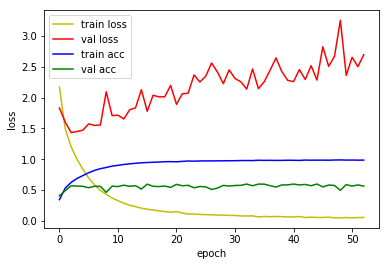

4815/4815 [==============================] - 2s 455us/sample - loss: 1.5887 - acc: 0.5277
Loss: 1.5887069164654424 Accuracy: 0.5277259

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1194 - acc: 0.3396
Epoch 00001: val_loss improved from inf to 1.71012, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_4_conv_checkpoint/001-1.7101.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.1194 - acc: 0.3396 - val_loss: 1.7101 - val_acc: 0.4314
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4297 - acc: 0.5470
Epoch 00002: val_loss improved from 1.71012 to 1.30680, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_4_conv_checkpoint/002-1.3068.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.4297 - acc: 0.5470 - val_loss: 1.3068 - val_acc: 0.5938
Epoch 3/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2505 - acc: 0.9247
Epoch 00027: val_loss did not improve from 0.99402
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2506 - acc: 0.9247 - val_loss: 1.1688 - val_acc: 0.7028
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2380 - acc: 0.9297
Epoch 00028: val_loss did not improve from 0.99402
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2381 - acc: 0.9297 - val_loss: 1.0919 - val_acc: 0.7191
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2367 - acc: 0.9299
Epoch 00029: val_loss did not improve from 0.99402
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2368 - acc: 0.9299 - val_loss: 1.1350 - val_acc: 0.7119
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2271 - acc: 0.9318
Epoch 00030: val_loss did not improve from 0.99402
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1170 - acc: 0.9657
Epoch 00057: val_loss did not improve from 0.99402
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1171 - acc: 0.9656 - val_loss: 1.2206 - val_acc: 0.7286
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1058 - acc: 0.9696
Epoch 00058: val_loss did not improve from 0.99402
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1059 - acc: 0.9696 - val_loss: 1.1783 - val_acc: 0.7407
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1049 - acc: 0.9690
Epoch 00059: val_loss did not improve from 0.99402
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1050 - acc: 0.9690 - val_loss: 1.2544 - val_acc: 0.7328
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1091 - acc: 0.9692
Epoch 00060: val_loss did not improve from 0.99402
36805/36805 [===========

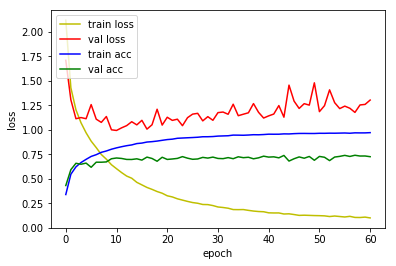

4815/4815 [==============================] - 2s 513us/sample - loss: 1.0736 - acc: 0.6712
Loss: 1.0736183411607119 Accuracy: 0.67123574

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1079 - acc: 0.3464
Epoch 00001: val_loss improved from inf to 1.70032, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_5_conv_checkpoint/001-1.7003.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.1079 - acc: 0.3464 - val_loss: 1.7003 - val_acc: 0.4307
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4060 - acc: 0.5512
Epoch 00002: val_loss improved from 1.70032 to 1.19155, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_5_conv_checkpoint/002-1.1916.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.4061 - acc: 0.5511 - val_loss: 1.1916 - val_acc: 0.6271
Epoch 3/500
36800/36805 [============================>.] -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3159 - acc: 0.9036
Epoch 00026: val_loss did not improve from 0.76074
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3159 - acc: 0.9036 - val_loss: 0.7877 - val_acc: 0.7761
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3055 - acc: 0.9089
Epoch 00027: val_loss did not improve from 0.76074
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3056 - acc: 0.9088 - val_loss: 0.8502 - val_acc: 0.7645
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2946 - acc: 0.9103
Epoch 00028: val_loss did not improve from 0.76074
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2948 - acc: 0.9103 - val_loss: 0.8381 - val_acc: 0.7827
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2804 - acc: 0.9141
Epoch 00029: val_loss did not improve from 0.76074
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9620
Epoch 00056: val_loss did not improve from 0.76074
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1277 - acc: 0.9620 - val_loss: 0.8734 - val_acc: 0.7932
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1306 - acc: 0.9616
Epoch 00057: val_loss did not improve from 0.76074
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1306 - acc: 0.9616 - val_loss: 0.9321 - val_acc: 0.7829
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1262 - acc: 0.9625
Epoch 00058: val_loss did not improve from 0.76074
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1263 - acc: 0.9625 - val_loss: 0.9783 - val_acc: 0.7738
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1220 - acc: 0.9645
Epoch 00059: val_loss did not improve from 0.76074
36805/36805 [===========

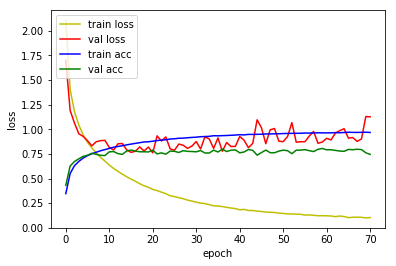

4815/4815 [==============================] - 3s 552us/sample - loss: 0.8717 - acc: 0.7458
Loss: 0.8716720554935102 Accuracy: 0.7457944

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1971 - acc: 0.3080
Epoch 00001: val_loss improved from inf to 1.69530, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_6_conv_checkpoint/001-1.6953.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.1970 - acc: 0.3080 - val_loss: 1.6953 - val_acc: 0.4407
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3857 - acc: 0.5571
Epoch 00002: val_loss improved from 1.69530 to 1.11963, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_6_conv_checkpoint/002-1.1196.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.3858 - acc: 0.5571 - val_loss: 1.1196 - val_acc: 0.6546
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3528 - acc: 0.8961
Epoch 00025: val_loss did not improve from 0.48197
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3529 - acc: 0.8960 - val_loss: 0.4894 - val_acc: 0.8609
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3467 - acc: 0.8979
Epoch 00026: val_loss did not improve from 0.48197
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3468 - acc: 0.8978 - val_loss: 0.4982 - val_acc: 0.8661
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3332 - acc: 0.9021
Epoch 00027: val_loss did not improve from 0.48197
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3332 - acc: 0.9021 - val_loss: 0.5090 - val_acc: 0.8523
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3218 - acc: 0.9051
Epoch 00028: val_loss did not improve from 0.48197
36805/36805 [===========

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1798 - acc: 0.9457
Epoch 00053: val_loss did not improve from 0.43486
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1798 - acc: 0.9457 - val_loss: 0.4602 - val_acc: 0.8772
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1679 - acc: 0.9498
Epoch 00054: val_loss did not improve from 0.43486
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1679 - acc: 0.9498 - val_loss: 0.4614 - val_acc: 0.8800
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1661 - acc: 0.9494
Epoch 00055: val_loss did not improve from 0.43486
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1661 - acc: 0.9494 - val_loss: 0.4360 - val_acc: 0.8821
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1697 - acc: 0.9491
Epoch 00056: val_loss did not improve from 0.43486
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1080 - acc: 0.9678
Epoch 00083: val_loss did not improve from 0.43486
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1081 - acc: 0.9678 - val_loss: 0.4739 - val_acc: 0.8777
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1041 - acc: 0.9691
Epoch 00084: val_loss did not improve from 0.43486
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1041 - acc: 0.9691 - val_loss: 0.4961 - val_acc: 0.8775
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1021 - acc: 0.9702
Epoch 00085: val_loss did not improve from 0.43486
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1021 - acc: 0.9702 - val_loss: 0.5455 - val_acc: 0.8728
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1042 - acc: 0.9685
Epoch 00086: val_loss did not improve from 0.43486
36805/36805 [===========

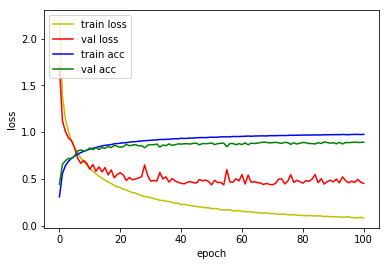

4815/4815 [==============================] - 3s 565us/sample - loss: 0.5385 - acc: 0.8536
Loss: 0.5385464418838081 Accuracy: 0.85358256

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3530 - acc: 0.2590
Epoch 00001: val_loss improved from inf to 1.84534, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_7_conv_checkpoint/001-1.8453.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.3531 - acc: 0.2590 - val_loss: 1.8453 - val_acc: 0.3941
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5085 - acc: 0.5105
Epoch 00002: val_loss improved from 1.84534 to 1.14646, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_7_conv_checkpoint/002-1.1465.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.5086 - acc: 0.5104 - val_loss: 1.1465 - val_acc: 0.6466
Epoch 3/500
36800/36805 [============================>.] -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2517 - acc: 0.9254
Epoch 00024: val_loss did not improve from 0.29356
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2517 - acc: 0.9254 - val_loss: 0.3138 - val_acc: 0.9157
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2432 - acc: 0.9262
Epoch 00025: val_loss did not improve from 0.29356
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2432 - acc: 0.9262 - val_loss: 0.3198 - val_acc: 0.9119
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2355 - acc: 0.9289
Epoch 00026: val_loss did not improve from 0.29356
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2358 - acc: 0.9288 - val_loss: 0.3316 - val_acc: 0.9005
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2300 - acc: 0.9286
Epoch 00027: val_loss improved from 0.29356 to 0.28872, saving model to mod

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1178 - acc: 0.9632
Epoch 00052: val_loss did not improve from 0.24163
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1178 - acc: 0.9632 - val_loss: 0.2749 - val_acc: 0.9262
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1136 - acc: 0.9643
Epoch 00053: val_loss did not improve from 0.24163
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1135 - acc: 0.9643 - val_loss: 0.2644 - val_acc: 0.9290
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9661
Epoch 00054: val_loss improved from 0.24163 to 0.23680, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_7_conv_checkpoint/054-0.2368.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1110 - acc: 0.9661 - val_loss: 0.2368 - val_acc: 0.9369
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9796
Epoch 00081: val_loss did not improve from 0.22804
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0671 - acc: 0.9796 - val_loss: 0.2664 - val_acc: 0.9345
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9808
Epoch 00082: val_loss did not improve from 0.22804
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0636 - acc: 0.9808 - val_loss: 0.2500 - val_acc: 0.9369
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9802
Epoch 00083: val_loss did not improve from 0.22804
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0660 - acc: 0.9802 - val_loss: 0.2808 - val_acc: 0.9376
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9813
Epoch 00084: val_loss did not improve from 0.22804
36805/36805 [===========

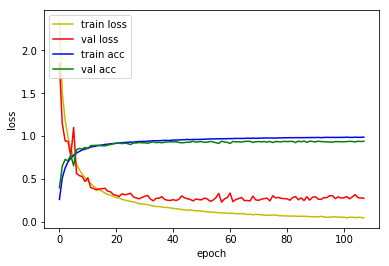

4815/4815 [==============================] - 3s 592us/sample - loss: 0.2878 - acc: 0.9215
Loss: 0.2878187735782605 Accuracy: 0.9214953

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3171 - acc: 0.2796
Epoch 00001: val_loss improved from inf to 1.81445, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_8_conv_checkpoint/001-1.8145.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 2.3171 - acc: 0.2796 - val_loss: 1.8145 - val_acc: 0.4482
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4596 - acc: 0.5391
Epoch 00002: val_loss improved from 1.81445 to 1.05789, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_8_conv_checkpoint/002-1.0579.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.4596 - acc: 0.5391 - val_loss: 1.0579 - val_acc: 0.6895
Epoch 3/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1689 - acc: 0.9483
Epoch 00023: val_loss did not improve from 0.18113
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1689 - acc: 0.9483 - val_loss: 0.1931 - val_acc: 0.9469
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1590 - acc: 0.9518
Epoch 00024: val_loss did not improve from 0.18113
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1590 - acc: 0.9518 - val_loss: 0.1857 - val_acc: 0.9469
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1558 - acc: 0.9521
Epoch 00025: val_loss did not improve from 0.18113
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1559 - acc: 0.9521 - val_loss: 0.2000 - val_acc: 0.9439
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1520 - acc: 0.9532
Epoch 00026: val_loss improved from 0.18113 to 0.17953, saving model to model/checkpoint

36800/36805 [============================>.] - ETA: 0s - loss: 0.0634 - acc: 0.9806
Epoch 00051: val_loss did not improve from 0.16981
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0634 - acc: 0.9806 - val_loss: 0.1901 - val_acc: 0.9483
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0609 - acc: 0.9814
Epoch 00052: val_loss did not improve from 0.16981
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0610 - acc: 0.9814 - val_loss: 0.1853 - val_acc: 0.9529
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0657 - acc: 0.9801
Epoch 00053: val_loss did not improve from 0.16981
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0657 - acc: 0.9801 - val_loss: 0.1895 - val_acc: 0.9490
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9828
Epoch 00054: val_loss did not improve from 0.16981
36805/36805 [========================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9907
Epoch 00081: val_loss did not improve from 0.16981
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0319 - acc: 0.9907 - val_loss: 0.2100 - val_acc: 0.9490
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9895
Epoch 00082: val_loss did not improve from 0.16981
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0340 - acc: 0.9895 - val_loss: 0.2174 - val_acc: 0.9490
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9892
Epoch 00083: val_loss did not improve from 0.16981
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0343 - acc: 0.9892 - val_loss: 0.1913 - val_acc: 0.9532
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9920
Epoch 00084: val_loss did not improve from 0.16981
36805/36805 [===========

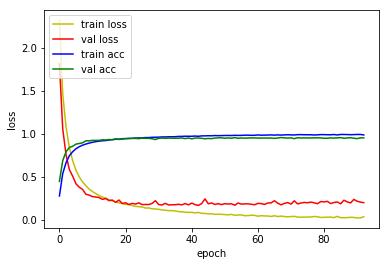

4815/4815 [==============================] - 3s 617us/sample - loss: 0.2140 - acc: 0.9369
Loss: 0.21403507006007438 Accuracy: 0.93686396

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9196 - acc: 0.4088
Epoch 00001: val_loss improved from inf to 1.21338, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_9_conv_checkpoint/001-1.2134.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.9195 - acc: 0.4089 - val_loss: 1.2134 - val_acc: 0.6499
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9192 - acc: 0.7101
Epoch 00002: val_loss improved from 1.21338 to 0.57270, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_025_DO_BN_9_conv_checkpoint/002-0.5727.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.9191 - acc: 0.7101 - val_loss: 0.5727 - val_acc: 0.8330
Epoch 3/500
36800/36805 [============================>.] 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0813 - acc: 0.9752
Epoch 00025: val_loss did not improve from 0.15205
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0813 - acc: 0.9752 - val_loss: 0.1727 - val_acc: 0.9504
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9756
Epoch 00026: val_loss did not improve from 0.15205
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0788 - acc: 0.9756 - val_loss: 0.1712 - val_acc: 0.9499
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0712 - acc: 0.9790
Epoch 00027: val_loss did not improve from 0.15205
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0712 - acc: 0.9791 - val_loss: 0.1607 - val_acc: 0.9541
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9786
Epoch 00028: val_loss did not improve from 0.15205
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9951
Epoch 00054: val_loss did not improve from 0.14876
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0196 - acc: 0.9951 - val_loss: 0.1986 - val_acc: 0.9476
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9938
Epoch 00055: val_loss did not improve from 0.14876
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0225 - acc: 0.9938 - val_loss: 0.1917 - val_acc: 0.9502
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9948
Epoch 00056: val_loss did not improve from 0.14876
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0200 - acc: 0.9948 - val_loss: 0.2389 - val_acc: 0.9443
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9914
Epoch 00057: val_loss did not improve from 0.14876
36805/36805 [========================


1D_CNN_custom_ch_32_DO_025_DO_BN_9_conv Model


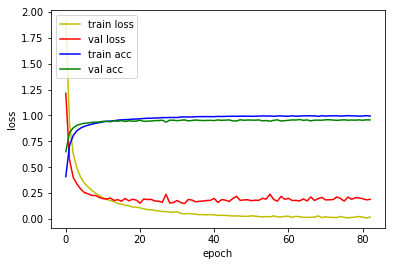

4815/4815 [==============================] - 3s 635us/sample - loss: 0.2189 - acc: 0.9385
Loss: 0.21890912561262507 Accuracy: 0.93852544



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_DO_025_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_DO_025_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_32_DO_025_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling 

4815/4815 [==============================] - 3s 639us/sample - loss: 0.8717 - acc: 0.7458
Loss: 0.8716720554935102 Accuracy: 0.7457944

1D_CNN_custom_ch_32_DO_025_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_55 (Activation)

4815/4815 [==============================] - 3s 685us/sample - loss: 0.2878 - acc: 0.9215
Loss: 0.2878187735782605 Accuracy: 0.9214953

1D_CNN_custom_ch_32_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_68 (Activation)

4815/4815 [==============================] - 4s 761us/sample - loss: 0.2189 - acc: 0.9385
Loss: 0.21890912561262507 Accuracy: 0.93852544


In [13]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_ch_32_DO_025_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling 

4815/4815 [==============================] - 4s 748us/sample - loss: 1.2662 - acc: 0.7045
Loss: 1.2661703642283644 Accuracy: 0.7044652

1D_CNN_custom_ch_32_DO_025_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_55 (Activation)

4815/4815 [==============================] - 4s 798us/sample - loss: 0.3288 - acc: 0.9188
Loss: 0.3288142160292974 Accuracy: 0.9187954

1D_CNN_custom_ch_32_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_68 (Activation)

4815/4815 [==============================] - 4s 862us/sample - loss: 0.2496 - acc: 0.9477
Loss: 0.24962142276677263 Accuracy: 0.94766355
